In [1]:
%matplotlib inline

I've added forward and centered finite difference operators to the `finite.py` file that we can use in these notes.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import finite
from IPython.display import display, clear_output

Here's a base class to help us make and test different timestepping methods. It is designed to solve a problem of the form
$$ \partial_t u = f(u, t).$$

In [3]:
class Timestepper:

    def __init__(self):
        self.t = 0
        self.iter = 0
        self.dt = None

    def step(self, dt):
        self.u = self._step(dt)
        self.t += dt
        self.iter += 1
        
    def evolve(self, dt, time):
        while self.t < time - 1e-8:
            self.step(dt)


class ExplicitTimestepper(Timestepper):

    def __init__(self, u, f):
        super().__init__()
        self.u = u
        self.f = f

In [4]:
L = 0.1
def IC(x):
    return np.exp(-(1+np.cos(x))**2/2/L**2)

## Lax-Friedrichs

This method is 
$$u_j^{n+1} = \frac{1}{2}(u_{j-1}^n+u_{j+1}^n) + \Delta t f(u^n).$$
We need to make an averaging operator called `A`. If we write the averaging operator as $A$, then the method becomes
$$u^{n+1} = A(u^n) + \Delta t f(u^n).$$

In [5]:
class LaxFriedrichs(ExplicitTimestepper):

    def __init__(self, u, f):
        super().__init__(u, f)
        N = len(u)
        A = sparse.diags([1/2, 1/2], offsets=[-1, 1], shape=[N, N])
        A = A.tocsr()
        A[0, -1] = 1/2
        A[-1, 0] = 1/2
        self.A = A

    def _step(self, dt):
        return self.A @ self.u + dt*self.f(self.u)

Test different centered differencing schemes
1. 2nd order
2. 4th order

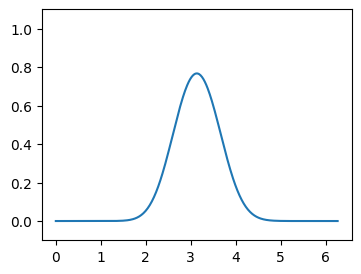

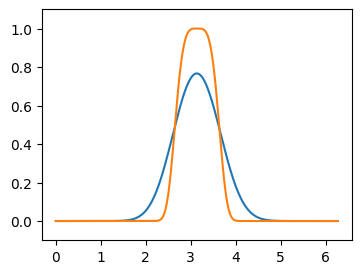

In [6]:
grid = finite.UniformPeriodicGrid(400, 2*np.pi)
x = grid.values

d = finite.CenteredFiniteDifference4(grid)
f = lambda u: d @ u
ts = LaxFriedrichs(IC(x), f)
dt = 0.5*grid.dx
output_cadence = 10

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, ts.u)
plt.ylim([-0.1, 1.1])
while ts.t < 2*np.pi:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(ts.u)
        clear_output(wait=True)
        display(fig)
plt.plot(x, IC(x))

## Leapfrog

This method is 
$$u_j^{n+1} = u_j^{n-1} + 2\Delta t f(u^n).$$
The tricky part here is that we cannot apply this on the first timestep, because we do not know $u_j^{n-1}$! For simplicity, we will take a Forward Euler on the first timestep, and then do Leapfrog from there.

In [7]:
class Leapfrog(ExplicitTimestepper):

    def _step(self, dt):
        if self.iter == 0:
            self.u_old = np.copy(self.u)
            return self.u + dt*self.f(self.u)
        else:
            u_temp = self.u_old + 2*dt*self.f(self.u)
            self.u_old = np.copy(self.u)
            return u_temp

Test different centered differencing schemes
1. 2nd order
2. 4th order

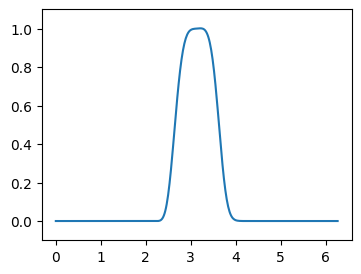

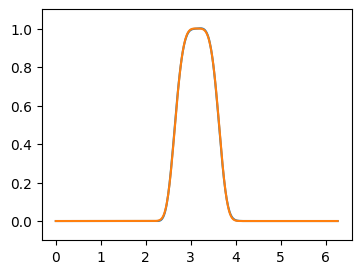

In [8]:
grid = finite.UniformPeriodicGrid(400, 2*np.pi)
x = grid.values

d = finite.CenteredFiniteDifference4(grid)
f = lambda u: d @ u
ts = Leapfrog(IC(x), f)
dt = 0.5*grid.dx
output_cadence = 10

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, ts.u)
plt.ylim([-0.1, 1.1])
while ts.t < 2*np.pi:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(ts.u)
        clear_output(wait=True)
        display(fig)
plt.plot(x, IC(x))

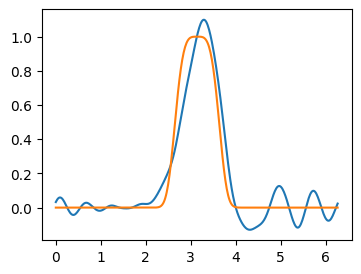

In [9]:
grid = finite.UniformPeriodicGrid(400, 2*np.pi)
x = grid.values

d = finite.CenteredFiniteDifference(grid)
f = lambda u: d @ u
ts = Leapfrog(IC(x), f)
dt = 0.5*grid.dx
output_cadence = 10

fig = plt.figure(figsize=(4,3))
fig.canvas.draw()
while ts.t < 50*2*np.pi:
    ts.step(dt)
plt.plot(x, ts.u)
plt.plot(x, IC(x))

## Lax-Wendorff

This method is 
$$u_j^{n+1} = u_j^{n} + \Delta t D(u^n) + \frac{1}{2}\Delta t^2 D^2(u^n).$$
Here we store separate functions for the first derivative, $D$, and the second derivative $D^2$.

In [10]:
class LaxWendroff(Timestepper):

    def __init__(self, u, f1, f2):
        self.t = 0
        self.iter = 0
        self.u = u
        self.f1 = f1
        self.f2 = f2

    def _step(self, dt):
        return self.u + dt*self.f1(self.u) + dt**2/2*self.f2(self.u)

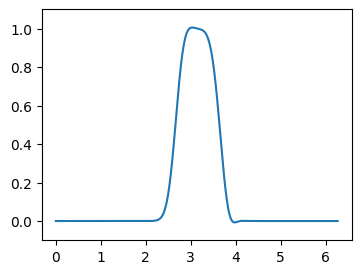

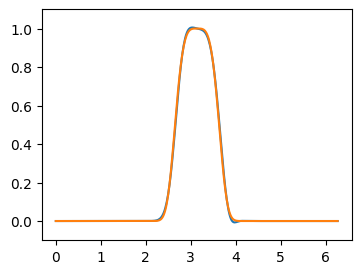

In [11]:
grid = finite.UniformPeriodicGrid(400, 2*np.pi)
x = grid.values

d1 = finite.CenteredFiniteDifference(grid)
f1 = lambda u: d1 @ u
d2 = finite.CenteredFiniteSecondDifference(grid)
f2 = lambda u: d2 @ u
ts = LaxWendroff(IC(x), f1, f2)
dt = 0.5*grid.dx
output_cadence = 10

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, ts.u)
plt.ylim([-0.1, 1.1])
while ts.t < 2*np.pi:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(ts.u)
        clear_output(wait=True)
        display(fig)
plt.plot(x, IC(x))